In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

# Open and read the “in” Matlab file
inputs = scipy.io.loadmat(r'.\data\in.mat')

In [2]:
# Get power traces as numpy array
inputs = inputs['in']

In [4]:
# 14900 4-bit inputs used for the attack 
np.shape(inputs)

(14900, 1)

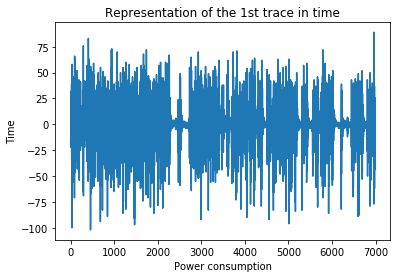

In [6]:
plt.plot(traces[0])
plt.title("Representation of the 1st trace in time")
plt.xlabel("Power consumption")
plt.ylabel("Time")
plt.show()

In [ ]:
# takes a 4-bit value of input and a 4-bit value of the hypothetical key
# returns the output of the SBox
def SBox(in_val, key):
    return sbox[in_val ^ key]

In [ ]:
# 4-bit to 4-bit S-box in PRESENT cipher
#       0   1   2   3   4   5   6   7   8   9   a   b   c   d   e   f
Sbox= (0xc,0x5,0x6,0xb,0x9,0x0,0xa,0xd,0x3,0xe,0xf,0x8,0x4,0x7,0x1,0x2)

In [ ]:
# Calculate the Hamming Weight of the guess
# Convert every possible value 0-16 to binary and count the 1s
# Store in look-up table
HammingWeight = [bin(n).count('1') for n in range(0,16)]

In [ ]:
# Construct the value-prediction matrix on variable y
# In this step we will predict all possible values of y, by using in and guessing all the values of the 4-bit key chunk, k.


In [ ]:
# Convert the value-prediction matrix into the power-prediction matrix by using the Hamming weight model

In [ ]:
# Open and read the “traces” Matlab file
traces = scipy.io.loadmat(r'.\data\traces.mat')

# Get power traces as numpy array
traces = traces['traces']

In [ ]:
# 14900 traces of 6990 time samples each
no_traces = np.shape(traces)

In [ ]:
# Run the attack with 500, 1k, 2k 4k, 8k and 12k power traces
# For every attack, rank the candidates from best to worst. 
# Plot the correct candidate’s ranking (e.g. 1st, 2nd etc.) for all these attacks.
# no_traces = 500

In [ ]:
# Construct the traces (measurement) matrix


In [ ]:
# For all possible k candidates, compute the column-wise correlation between the traces matrix and the power-prediction matrix

In [ ]:
# Rank the key candidates from best to worst, based on the absolute value of the correlation function
# The top candidate will be chosen based on absolute correlation.

In [ ]:
# For every time sample, plot the absolute correlation value for every k candidate